# Neural network models

This notebook picks up after the `simple_models` notebook. After trying a range of classification algorithms, we'll try out some of the neural network models in [1]. These include fully-connected models of varying layer sizes, and finally convolutional models including the famous LeNet-5. 

Along the way, we'll be using Keras which is a library sitting on top of Theano or Tensorflow. This allows easy construction, training and evaluation of neural nets. Before we get started, here's a recap of the `simple_models` notebook models.

`[1]` - [Gradient-Based Learning Applied to Document Recognition](http://yann.lecun.com/exdb/publis/pdf/lecun-98.pdf),  LeCun et al, Nov 1998

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import pickle

plt.style.use('fivethirtyeight')
# plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = 'Helvetica'
plt.rcParams['font.monospace'] = 'Consolas'
plt.rcParams['font.size'] = 16
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['lines.linewidth'] = 2

%matplotlib inline

# for auto-reloading external modules
%load_ext autoreload
%autoreload 2

## Load pickle files

The original data files are processed using the `convert_data.py` script, and written out to pickle files. We can load these in as numpy arrays.

In [2]:
# Set up the file directory and names
DIR = '../input/'
X_TRAIN = DIR + 'train-images-idx3-ubyte.pkl'
Y_TRAIN = DIR + 'train-labels-idx1-ubyte.pkl'
X_TEST = DIR + 't10k-images-idx3-ubyte.pkl'
Y_TEST = DIR + 't10k-labels-idx1-ubyte.pkl'

def load_data():
    '''Loads pickled ubyte files with MNIST data
    INPUT: X_train_file, y_train_file - strings with training filenames
           X_test_file, y_test_File - strings with test filenames
    RETURNS: Tuple with (X_train, y_train, X_test, y_test)
    '''
    print('Loading pickle files')
    try:
        X_train = pickle.load( open( X_TRAIN, "rb" ) )
        y_train = pickle.load( open( Y_TRAIN, "rb" ) )
        X_test = pickle.load( open( X_TEST, "rb" ) )
        y_test = pickle.load( open( Y_TEST, "rb" ) )
    except:
        print('Error loading pickle file')
        return None
    
    return (X_train, y_train, X_test, y_test)

X_train, y_train, X_test,  y_test = load_data()

Loading pickle files


## Helper functions

Before evaluating some models on the images, let's create some helper functions we can re-use later on. These deal with converting images to and from 1d and 2d versions, plotting images, resizing them, etc.

In [3]:
def flatten_images(X):
    ''' Converts images to 1-d vectors
    INPUT: X - Input array of shape [n, w, h]
    RETURNS: Numpy array of shape [n, w*h]
    '''
    n, w, h = X.shape
    X_flat = X.reshape((n, w * h))
    return X_flat

def square_images(X, w=None, h=None):
    '''Converts single-vector images into square images 
    INPUT: X - numpy array of images in single-vector form
           w - width of images to convert to
           h - height of images to convert to
    RETURNS: Numpy array of shape [n, w, h]
    '''
    
    assert X.shape[1] == w * h, "Error - Can't square array of shape {} to {}".format(X.shape, (w, h))
    n = X.shape[0]
    X_square = X.reshape((n, w, h))
    return X_square


N_TRAIN, W, H = X_train.shape
N_TEST, w_test, h_test = X_test.shape

# Flatten the images
X_train = flatten_images(X_train)
X_test = flatten_images(X_test)

# Do some checks on the data
assert N_TRAIN == 60000, 'Error - expected 60000 training images, got {}'.format(N_TRAIN)
assert N_TEST == 10000, 'Error - expected 60000 training images, got {}'.format(N_TEST)
assert W == w_test, 'Error - width mismatch. Train {}, Test {}'.format(w, w_test)
assert H == h_test, 'Error - height mismatch. Train {}, Test {}'.format(h, h_test)

assert np.array_equal(X_train, flatten_images(square_images(X_train, W, H)))
assert X_train.shape[0] == y_train.shape[0]
assert X_test.shape[0] == y_test.shape[0]

print('Loaded train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Loaded test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))


Loaded train images shape (60000, 784), labels shape (60000, 1)
Loaded test images shape (10000, 784), labels shape (10000, 1)


## Data preparation

This section sets up global constants used in all models (to ensure a fair comparison). It also prepares the data by converting y values to one-hot, and normalizing X inputs.

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer, StandardScaler

# Keras Common configuration
SEED = 1234 # Fix the seed for repeatability
N_JOBS=-2 # Leave 1 core free for UI updates
VERBOSE=2 # 3 is the most verbose level
EPOCHS = 20 # todo ! Check how many epochs in the paper
BATCH = 256 # todo ! Check this in the paper too


def stratified_subsample(X, y, num_rows):
    '''Creates a stratified subsample of X and y
    INPUT: X and y, numpy arrays
    RETURNS: subset of X and y, maintaining class balances
    '''
    # Create a stratified, shuffled subset of the training data if needed
    N = X.shape[0]
    if num_rows < N:
        print('Reducing size from {} to {} examples'.format(N, num_rows))
        new_X, _, new_y, _ = train_test_split(X_train, y_train, # Undersample by dropping "test" data
                                              train_size=N, random_state=SEED)    

def onehot_encode_y(y_train, y_test):
    '''Convert y_train and y_test to a one-hot encoding version
    INPUT: y_train - np.array of size (n_train,)
           y_test - np.array of size (n_test,)
    RETURNS: y_train - np.array of size (n_train, n_classes)
             y_test - np.arary of size (n_test, n_classes)
    '''    
    print('Converting y variables to one-hot encoding..')
    lbe = LabelBinarizer()
    lbe.fit(y_train)
    y_train = lbe.transform(y_train)
    y_test = lbe.transform(y_test)
    return y_train, y_test

def z_norm_X(X_train, X_test):
    '''Z-normalizes X_train and X_test with 0 mean and 1 std. dev.
    INPUT: X_train - training set
           X_test - test set
    RETURNS: X_train - normalized version of same size
             X_test - normalized version (using X_train parameters)
    '''
    print('Z-normalizing X data..')    
    std = StandardScaler()
    X_train = X_train.astype(np.float32)
    X_test = X_test.astype(np.float32)
    std.fit(X_train)
    X_train = std.transform(X_train)
    X_test = std.transform(X_test)
    return X_train, X_test
    
y_train, y_test = onehot_encode_y(y_train, y_test)
X_train, X_test = z_norm_X(X_train, X_test)
scores = dict()

print('Train images shape {}, labels shape {}'.format(X_train.shape, y_train.shape))
print('Test images shape {}, labels shape {}'.format(X_test.shape, y_test.shape))

Converting y variables to one-hot encoding..
Z-normalizing X data..
Train images shape (60000, 784), labels shape (60000, 10)
Test images shape (10000, 784), labels shape (10000, 10)


## [1] C.5 - Baseline fully-connected models (original dataset)

We'll first compare the performance of different fully-connected models on fully-connected networks of varying layers and size. These are all trained on the 28x28 dataset.

## Helper class

In [25]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import SGD

# Create a dictionary to store model training and test info
models = dict()

class KerasFCModel(object):
    
    def __init__(self, model_name, model_type, input_dim, layers, 
                 activation, output_activation, verbose=2):
        '''Initializes a new keras model'''
        self.model_name = model_name
        self.verbose = verbose
        
        model = model_type
        for idx, size in enumerate(layers):
            
            # First layer has to take input from image files
            if idx == 0:
                if self.verbose == 2:
                    print('Adding input dense layer, input dim {}, dim {}'.format(input_dim, size))
                model.add(Dense(size, input_dim=input_dim))
                model.add(Activation(activation))
                
            # Last layer has to include the output activation
            elif idx == len(layers) - 1:
                if self.verbose == 2:
                    print('Adding dense layer {}, size {}, activation {}'.format(idx, size, activation))
                model.add(Dense(size))
                model.add(Activation(output_activation))
                
            # Layers other than first and last have standard activation
            else: 
                if self.verbose == 2:
                    print('Adding output layer {}, size {}, activation {}'.format(idx, size, output_activation))
                model.add(Dense(size))
                model.add(Activation(activation))
                
        if self.verbose > 0:
            print('Model summary:\n')
            model.summary()
        
        self.model = model
        
    def compile_model(self, loss, optimizer, metrics):
        '''Compile the model'''
        self.metrics = metrics
        self.loss = loss
        self.optimizer = optimizer
        # Need to flip error vs accuracy 
        metrics = ['acc' if metric is 'error' else metric for metric in metrics]
        self.model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
          
    def fit(self, X, y, epochs, batch_size):
        '''Fit model to training data'''
        self.history = self.model.fit(X, y, epochs=epochs, batch_size=batch_size, verbose=self.verbose)

    def evaluate(self, X, y, batch_size):
        '''Evaluates the model on test data'''
        output = self.model.evaluate(X, y, batch_size=batch_size)
        results = dict()
        for idx, metric in enumerate(self.model.metrics_names):
            if metric == 'acc':
                results['error'] = 1.0 - output[idx]
            else:
                results[metric] = output[idx]                
        self.results = results
    
    def report(self):
        '''Prints a recap of the model, how it was trained, and performance'''
        report = dict()
        if self.verbose > 0:
            report['model_info'] = self.model.summary()
            report['loss'] = self.loss
            report['optimizer'] = self.optimizer.get_config()
            report['metrics'] = self.metrics
            report['history'] = self.history
        report['results'] = self.results
        return report
    

In [19]:
# Helper function to evaluate fully-connected models
def evaluate_fc_model(name, layers, activation, optimizer,
                            X_tr, y_tr, X_te, y_te,
                            epochs, batch_size,
                            verbose=2):
    """Creates, trains, and evaluates neural network on provided data"""
    
    print('Creating Keras model {}'.format(name))
    model = KerasFCModel(model_name=name, model_type=Sequential(), 
                           input_dim=784, layers=layers, 
                           activation=activation, output_activation='softmax',
                           verbose=verbose)

    print('Compiling model')
    model.compile_model(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['error'])

    print('Training model')
    model.fit(X_tr, y_tr, epochs=epochs, batch_size=batch_size)

    print('Evaluating model')
    model.evaluate(X_te, y_te, batch_size=batch_size)

    print('\nTest results: {:.4f} error'.format(model.report()['results']['error']))
    return model


## Fully connected single-hidden layer networks

In [39]:
%%time

fc_results = dict()
fc_results['fc-300-10'] = evaluate_fc_model('fc-300-10', layers=(300,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)
    

Creating Keras model fc-300-10
Compiling model
Training model
Evaluating model
 6400/10000 [==================>...........] - ETA: 0s
Test results: 0.0290 error
CPU times: user 11.6 s, sys: 4.56 s, total: 16.2 s
Wall time: 16.2 s


In [40]:
%%time

# FC 1000-10
fc_results['fc-1000-10'] = evaluate_fc_model('fc-1000-10', layers=(1000,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-6, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-1000-10
Compiling model
Training model
Evaluating model
 9984/10000 [============================>.] - ETA: 0s
Test results: 0.0273 error
CPU times: user 13.7 s, sys: 4.88 s, total: 18.5 s
Wall time: 18.6 s


## Two hidden layer fully connected networks

In [41]:
%%time

# FC 300-100-10
fc_results['fc-300-100-10'] = evaluate_fc_model('fc-300-100-10', layers=(300,100,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-300-100-10
Compiling model
Training model
Evaluating model
 9984/10000 [============================>.] - ETA: 0s
Test results: 0.0273 error
CPU times: user 12.7 s, sys: 244 ms, total: 13 s
Wall time: 12.9 s


In [42]:
%%time

# FC 500-150-10
fc_results['fc-500-150-10'] = evaluate_fc_model('fc-500-150-10', layers=(500,150,10), activation='tanh', 
                                            optimizer=SGD(lr=0.1, decay=1e-5, momentum=0.9, nesterov=True),
                                            X_tr=X_train, y_tr=y_train, X_te=X_test, y_te=y_test,
                                            epochs=EPOCHS, batch_size=BATCH,
                                            verbose=0)


Creating Keras model fc-500-150-10
Compiling model
Training model
Evaluating model
10000/10000 [==============================] - 0s     

Test results: 0.0266 error
CPU times: user 12.3 s, sys: 304 ms, total: 12.6 s
Wall time: 12.6 s


In [43]:
# Compile the FC results so far into a dataframe for easy plotting

fc_scores = {result: value.results['error'] for result, value in fc_results.items()}
fc_scores_df = pd.DataFrame.from_dict(fc_scores, orient='index')

fc_scores_df.columns = ['error']
fc_scores_df['error'] *= 100.0
fc_scores_df = fc_scores_df.sort_values('error', ascending=True)
fc_scores_df.to_pickle('fc_scores.pkl')

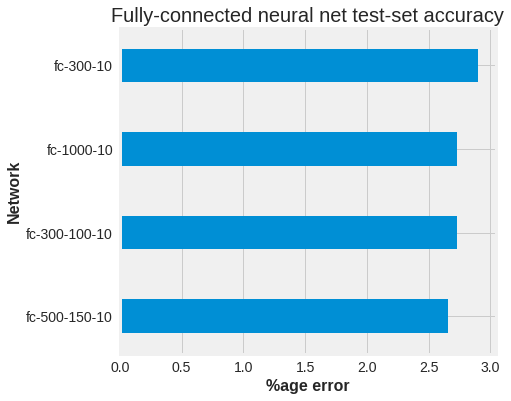

In [44]:
fig, ax = plt.subplots(1,1, figsize=(6,6))
fc_scores_df.plot.barh(width=0.4, ax=ax, legend=None)
ax.set(title="Fully-connected neural net test-set accuracy", ylabel="Network", xlabel="%age error");
plt.savefig('fc_scores.png', bbox_inches='tight', dpi=150)

# Convolutional neural networks

Now let's see how much further we can improve performance with convolutional neural networks. For the convolutional networks, we need a 2-d image instead of the flattened 1-d vector the fully connected networks used. We also need to add padding around each of the images.

In [48]:
# Load image pickle files
X_train, y_train, X_test,  y_test = load_data()
X_train.shape

Loading pickle files


(60000, 28, 28)

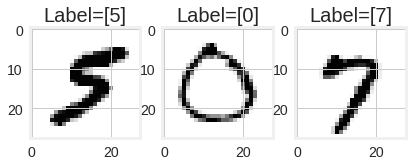

In [63]:
#Plot a few random numbers to sanity check their size and that they look correct

N = 3
indexes = np.random.choice(X_train.shape[0], N)
fig, ax = plt.subplots(1, N)

for num, idx in enumerate(indexes):
    
    ax[num].imshow(X_train[idx])
    ax[num].set(title="Label={}".format(y_train[idx]))

## Padding images to 32x32 while centering image

In [1], the images are padded to 32x32 to ensure every pixel of the input image ends up in the center of the receptive fields of the highest level feature receptors.

In [86]:
def image_border(image, size, fill):
    """
    Adds a border around the nupmy array of the gizen size and value
    """
    im_w, im_h = image.shape
    im_dtype = image.dtype
    
    new_image = np.full((im_w + (2 * size), im_h + (2 * size)),
                        fill_value=fill, dtype=im_dtype)
    new_image[size:im_h + size, size:im_w + size] = image
    
    assert new_image.dtype == image.dtype
    assert new_image.shape[0] == image.shape[0] + (2 * size)
    assert new_image.shape[1] == image.shape[1] + (2 * size)
    assert np.array_equal(image, new_image[size:size+im_h, size:size+im_w])
    return new_image
    
    
# test_image = np.full((32,32), fill_value=0, dtype=np.uint8)
# test_image[2:30, 2:30] = X_train[0]
# test_image

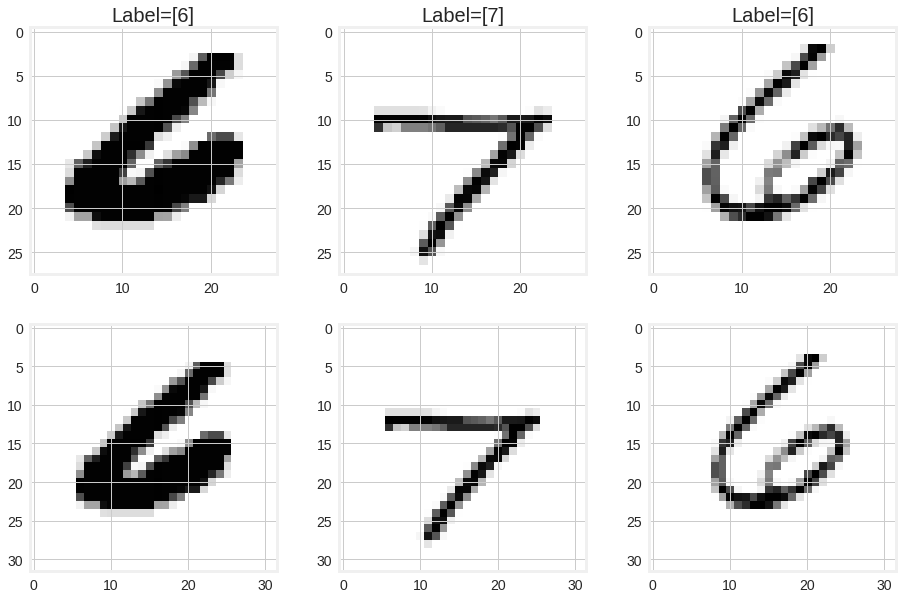

In [88]:
N = 3
indexes = np.random.choice(X_train.shape[0], N)
fig, ax = plt.subplots(2, N, figsize=(14,10))

for num, idx in enumerate(indexes):
    
    ax[0, num].imshow(X_train[idx])
    ax[0, num].set(title="Label={}".format(y_train[idx]))
    
    ax[1, num].imshow(image_border(X_train[idx], 2, 0))
#     ax[0, num].set(title="Label={}".format(y_train[idx]))

# plt.imshow(image_border(X_train[0], 2, 0))

In [94]:
from tqdm import tqdm

# resize all the training and test images
n_train = X_train.shape[0]
n_test = X_test.shape[0]


def resize_images(images, description):
    """
    Iterates through lowest order dimension, and resizes images
    """
    new_images = np.zeros((images.shape[0], 32, 32))

    for index in tqdm(range(images.shape[0]), desc=description):
        new_images[index] = image_border(images[index], 2, 0)
        
    return new_images


X_resize_train = resize_images(X_train, "Resizing train images")
X_resize_test = resize_images(X_test, "Resizing test images")

X_train = X_resize_train
X_test = X_resize_test

print('New X_train shape: {}, new x_test shape: {}'.format(X_train.shape, X_test.shape))

Resizing test images: 100%|██████████| 10000/10000 [00:00<00:00, 32210.80it/s]

New X_train shape: (60000, 32, 32), new x_test shape: (10000, 32, 32)
